In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 
from torch.nn.utils import prune

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

# data setting


In [2]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [3]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.preprocessing import RobustScaler

# Assuming X_train, X_test, y_train, y_test are your dataframes or arrays

# 將 X_train 和 X_test 轉換為張量並移動到指定設備上
x_in = torch.tensor(X_train.values, device=device, dtype=torch.float)
x_val = torch.tensor(X_test.values, device=device, dtype=torch.float)

# 對 y_train 和 y_test 進行 RobustScaler 縮放後轉換為張量
scaler = RobustScaler()
y_in_s = torch.tensor(scaler.fit_transform(y_train.values.reshape(-1, 1)), device=device, dtype=torch.float)
y_val_s = torch.tensor(scaler.transform(y_test.values.reshape(-1, 1)), device=device, dtype=torch.float)

# 將 y_train 和 y_test 直接轉換為張量
y_in = torch.tensor(y_train.values, device=device, dtype=torch.float)
y_val = torch.tensor(y_test.values, device=device, dtype=torch.float)

class nn_model(nn.Module):
    def __init__(self):
        super(nn_model, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 5)
        self.output = nn.Linear(5, 1)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.output(x)
        return x
    def init_weights(m, k=1, gain=100):
        for i in m:
            if isinstance(i, nn.Linear):
                nn.init.xavier_normal_(i.weight, gain=gain)
                i.bias.data.fill_(k)
    #l2 reguliaztion
    def l2_loss(model, lambda0 = 0.001):
        paras = []
        for para in model.parameters():
            paras.append(para.view(-1))
        return lambda0* torch.square(torch.cat(paras)).sum()
    #set DO and BN layer
    def DO_BN(model,DO:bool,BN:bool):
        dropout_probs = [ 0.1,0.1,0.1]
        for name, module in model.named_modules():
            if isinstance(module, nn.Dropout):
                module.p =  dropout_probs.pop(0) if DO else 0
            if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
                module.track_running_stats = BN

    def forward(model,x,y,l2):
        y_pred = model(x)
        loss = nn.functional.mse_loss(y_pred,y).to(device)
        if l2:
            loss+=  self.l2_loss(model)
        return loss
        

import torch.nn.utils.prune as prune

def prune_and_evaluate(model, layer, neuron_index, X_train, y_train, baseline_mse, tolerance=0.01):
    # 1. 生成遮罩
    mask = torch.ones(layer.weight.shape, device=layer.weight.device)
    mask[:, neuron_index] = 0
    
    # 2. 應用遮罩
    prune.custom_from_mask(layer, name='weight', mask=mask)
    
    # 3. 訓練遮罩後的模型
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    pruned_loss = train_model(model, criterion, optimizer, X_train, y_train)
    
    # 4. 計算新的 MSE
    pruned_mse = calculate_mse(model, X_train, y_train)
    
    # 5. 檢查 MSE 差距
    if pruned_mse - baseline_mse <= tolerance:
        print(f'Neuron {neuron_index} pruned successfully.')
    else:
        print(f'Neuron {neuron_index} not pruned, reverting changes.')
        prune.remove(layer, 'weight')

    return pruned_mse

In [6]:
#Xavier initialization
def init_weights(m, k=1, gain=10):
    for i in m:
        if isinstance(i, nn.Linear):
            nn.init.xavier_normal_(i.weight, gain=gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()
#set DO and BN layer
def DO_BN(model,DO:bool,BN:bool):
    dropout_probs = [ 0.1,0.1,0.1]
    for name, module in model.named_modules():
        if isinstance(module, nn.Dropout):
            module.p =  dropout_probs.pop(0) if DO else 0
        if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
            module.track_running_stats = BN

def forward(model,x,y,l2):
    y_pred = model(x)
    loss = nn.functional.mse_loss(y_pred,y).to(device)
    if l2:
        loss+=  l2_loss(model)
    return loss
    


# 遮罩和判定過程
def mask_and_prune(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            # 複製一份模型以便比較 MSE
            model_copy = model
            # 遮罩隱藏節點
            prune.l1_unstructured(layer, name='weight', amount=0.0)
            # 移除遮罩
            prune.remove(layer, name='weight')
            # 如果 MSE 差距小於閾值，則移除該節點
            if calculate_mse_diff(model_copy, model, threshold =0.1) :
                prune.l1_unstructured(layer, name='weight', amount=1.0)

def calculate_mse_diff(model_copy, model2, threshold= 0.1):
    return (forward(model_copy,x_val,y_val_s)-forward(model2,x_val,y_val_s) ) < threshold





In [7]:
#trian process
def training(model,EB = True, LG = False,UA= False, DO = False, BN = False, l2 = True,
             regulization = True,initial_lr = 1e-3, stopping_lr = 6e-5, stopping_error = 0.05 , stopping_epochs = 75):
    #set old model to output_model when running regulization
    if regulization:
        output_model = model
    else:
        init_weights(model,0.1,1)
        print(1)
   #activate DO and BNlayer or not
    DO_BN(model,DO,BN)
    # Disable tracking running statistics
    if UA and DO: print("Warning: Some error may occur for DO+ReduceLROnPlateau scheduler. Consider changing to CosineAnnealingLR scheduler.")
    #set Adam to be optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    #set learning scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,verbose=True,
                                                              cooldown=10, min_lr=0, eps=1e-05)
    epochs = 0
    loss_in_list = []
    loss_out_list = []
    while True:
        #forward
        epochs += 1
        model.eval()# 切換到評估模式
        loss_out = forward(model,x_val,y_val_s,l2)

        model.train()  # 切換到訓練模式
        loss_in = forward(model,x_in,y_in_s,l2)
  
        #store loss values
        loss_in_list.append(loss_in.item())
        loss_out_list.append(loss_out.item())
        
        #check LG critiria
        if (loss_in < stopping_error) & LG:    
            print("LG stop")
            break      

        #backward
        optimizer.zero_grad()
        loss_in.backward()
        optimizer.step()
        #check UA critiria
        lr_scheduler.step(loss_in)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
        if  UA :
            for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1.02
            if (current_lr<stopping_lr) :
                print('UA stop')
                break
        if regulization:
            output_model = model
            print('update new model')                 

        #check EB critiria
        if (epochs >= stopping_epochs) & EB:
            print("EB stop")
            if regulization:
                if ~UA and ~LG and (loss_in < stopping_error):
                    output_model = model
                    print('new model accept')
                else:
                    print("unacceptable model")
            break


    print(f'Training finished in {epochs} epochs.')
    
    if regulization:
        return loss_in_list,loss_out_list,stopping_error, output_model
    return loss_in_list, loss_out_list, stopping_error


In [8]:
#plot errors
def draw_lr_step(loss_in_list,loss_out_list,stopping_error):
    # Assuming you have the epoch numbers as a list
    epoch_list = list(range(1, len(loss_in_list)+1))

    # Assuming you have the lists for loss_in and loss_out

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, loss_in_list, label='Loss In')
    plt.plot(epoch_list, loss_out_list, label='Loss Out')
    plt.axhline(y=stopping_error, color='gray', linestyle='--',
                linewidth=1.5, label='Stopping Value = '+str(stopping_error))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of LG weight tuning')
    plt.legend()
    plt.ylim(0, 1)
    plt.scatter(epoch_list[-1], loss_out_list[-1], color='red', s=100, label='Last Point out')
    plt.text(epoch_list[-1], loss_out_list[-1]+0.03, f'  {loss_out_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.scatter(epoch_list[-1], loss_in_list[-1], color='red', s=100, label='Last Point in')
    plt.text(epoch_list[-1], loss_in_list[-1]+0.03, f'  {loss_in_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.grid(True)
    plt.show()


In [9]:
def draw_pred_reggsion(model,print_error = True):
    model.eval()
    y_pred_val_s = model(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
    y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
    loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
    if print_error:
        print(torch.Tensor.cpu(loss1).tolist())
        print(torch.Tensor.cpu(loss2).tolist())
        

    y_pred_val_list = y_pred_val.tolist()
    y_val_list = y_val.tolist()
    # Perform linear regression
    slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
    plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
    plt.xlabel('Prediction')
    plt.ylabel('House Price')
    plt.title('Regression line between Prediction and House Price')
    plt.legend()
    plt.grid(True)
    plt.show()



## Best Model: 11 hidden  with RELU act

N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, 50),
    nn.BatchNorm1d(50, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(50, 11),
    nn.BatchNorm1d(11, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(11, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [10]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [49]:

def prune_and_evaluate(model, layer, neuron_index, X_train, y_train, baseline_mse, tolerance=0.01):
    # 1. 生成遮罩
    mask = torch.ones(layer.weight.shape, device=layer.weight.device)
    mask[:, neuron_index] = 0
    
    # 2. 應用遮罩
    prune.custom_from_mask(layer, name='weight', mask=mask)
    
    # 3. 訓練遮罩後的模型
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    pruned_loss = train_model(model, criterion, optimizer, X_train, y_train)
    
    # 4. 計算新的 MSE
    pruned_mse = calculate_mse(model, X_train, y_train)
    
    # 5. 檢查 MSE 差距
    if pruned_mse - baseline_mse <= tolerance:
        print(f'Neuron {neuron_index} pruned successfully.')
    else:
        print(f'Neuron {neuron_index} not pruned, reverting changes.')
        prune.remove(layer, 'weight')

    return pruned_mse

In [36]:
def mask_node(layer,i):
        mask = torch.ones(layer.weight.shape, device=layer.weight.device)
        mask[:, i] = 0 
        original_weight = layer.weight.data.clone()
        prune.custom_from_mask(layer, name='weight', mask=mask)
        return original_weight 
        

def prune_node(model,n_layer = 1, n_node = 0, type = 1):
    n_layers = 1
    for layer in model.children():
        if isinstance(layer, nn.Linear):
             n_layers +=1
             if n_layers != n_layer:
                  continue
             k = print(layer.weight.shape[1])
             for i in range(k):
                  mask_node(layer,i)


                  


In [38]:
init_weights(model_11)

for i in model_11.children():
    if isinstance(i, nn.Linear):

        w =  mask_node(i,1)
        print(w)
        print(forward(model_11,x_in,y_in_s,False))
        i.weight = w
        print(forward(model_11,x_in,y_in_s,False))

        #print(i.weight.shape[0])
        

TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [39]:
init_weights(model_11)
for i in model_11.children():
    if isinstance(i, nn.Linear):
        print(i.weight)
        print(i.weight.shape[0])
        intial = mask_node(i,1) 
        print(i.weight)
        prune.remove(i, 'weight')
        i.weight = intial
        print(i.weight)







Parameter containing:
tensor([[ 0.0690,  1.0163,  0.8842,  ..., -0.9846,  0.1607, -1.1115],
        [ 1.6721, -0.0176, -0.6594,  ...,  0.1837, -0.1156, -0.0686],
        [ 0.7618, -1.0146, -1.2236,  ..., -0.2721, -0.2360, -0.0683],
        ...,
        [ 1.6078, -1.0034,  0.8559,  ..., -0.1999,  0.7677,  1.0454],
        [ 0.3058,  0.1860, -0.1262,  ...,  0.4351, -0.3665,  0.5230],
        [ 1.3425, -0.7729,  0.9368,  ...,  1.2903,  0.3828,  0.5491]],
       device='cuda:0', requires_grad=True)
100
tensor([[ 0.0690,  0.0000,  0.8842,  ..., -0.9846,  0.1607, -1.1115],
        [ 1.6721, -0.0000, -0.6594,  ...,  0.1837, -0.1156, -0.0686],
        [ 0.7618, -0.0000, -1.2236,  ..., -0.2721, -0.2360, -0.0683],
        ...,
        [ 1.6078, -0.0000,  0.8559,  ..., -0.1999,  0.7677,  1.0454],
        [ 0.3058,  0.0000, -0.1262,  ...,  0.4351, -0.3665,  0.5230],
        [ 1.3425, -0.0000,  0.9368,  ...,  1.2903,  0.3828,  0.5491]],
       device='cuda:0', grad_fn=<MulBackward0>)


TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [74]:
def mask_node(layer,i):
        mask = torch.ones(layer.weight.shape, device=layer.weight.device)
        mask[:, i] = 0 
        prune.custom_from_mask(layer, name='weight', mask=mask)
        layer.weight
        





def prune_node(model,n_layer = 1, n_node = 0, type = 1):
    n_layers = 1
    for layer in model.children():
        if isinstance(layer, nn.Linear):
             n_layers +=1
             if n_layers != n_layer:
                  continue
             k = print(layer.weight.shape[1])
             for i in range(k):
                  mask_node(layer,i)


                  
layer

Linear(in_features=11, out_features=1, bias=True)

In [14]:

for layer in model_11.children():
    if isinstance(layer, nn.Linear):
        print(layer.weight)
        mask = torch.ones(layer.weight.shape, device=layer.weight.device)
        mask[:, 1] = 0

        print(mask)
        
        # 2. 應用遮罩
        prune.custom_from_mask(layer, name='weight', mask=mask)
        print(layer.weight)
        prune.remove(layer, 'weight')
        print(layer.weight)


        

tensor([[-0.0024, -0.0000, -0.0217,  ...,  0.0648,  0.0113,  0.0049],
        [ 0.0607,  0.0000,  0.0213,  ..., -0.0389, -0.0579,  0.0533],
        [-0.0188, -0.0000, -0.0022,  ...,  0.0379,  0.0374,  0.0254],
        ...,
        [ 0.0482,  0.0000,  0.0642,  ...,  0.0635,  0.0312, -0.0045],
        [-0.0494, -0.0000,  0.0515,  ..., -0.0176,  0.0233, -0.0505],
        [-0.0325,  0.0000,  0.0431,  ...,  0.0272,  0.0595, -0.0515]],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.]], device='cuda:0')
tensor([[-0.0024, -0.0000, -0.0217,  ...,  0.0648,  0.0113,  0.0049],
        [ 0.0607,  0.0000,  0.0213,  ..., -0.0389, -0.0579,  0.0533],
        [-0.0188, -0.0000, -0.0022,  ...,  0.0379,  0.0374,  0.0254],
        ...,
        [ 0.0482,  0.000

### 1. weight tuning EB  + regularizing_EB with l2  loss 

#### train with EB

In [56]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 200

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)



1
Epoch 1: Loss In 1.1991024017333984, Loss Out 1.3529770374298096, Learning Rate 0.001
Epoch 2: Loss In 1.1792374849319458, Loss Out 1.3366121053695679, Learning Rate 0.001
Epoch 3: Loss In 1.1601243019104004, Loss Out 1.3208508491516113, Learning Rate 0.001
Epoch 4: Loss In 1.1417462825775146, Loss Out 1.3056937456130981, Learning Rate 0.001
Epoch 5: Loss In 1.1239584684371948, Loss Out 1.291111707687378, Learning Rate 0.001
Epoch 6: Loss In 1.106811285018921, Loss Out 1.277103304862976, Learning Rate 0.001
Epoch 7: Loss In 1.0894657373428345, Loss Out 1.2636574506759644, Learning Rate 0.001
Epoch 8: Loss In 1.0729458332061768, Loss Out 1.2507842779159546, Learning Rate 0.001
Epoch 9: Loss In 1.0564571619033813, Loss Out 1.2383557558059692, Learning Rate 0.001
Epoch 10: Loss In 1.0404036045074463, Loss Out 1.222001314163208, Learning Rate 0.001
Epoch 11: Loss In 1.0249027013778687, Loss Out 1.2043596506118774, Learning Rate 0.001
Epoch 12: Loss In 1.0090627670288086, Loss Out 1.18689

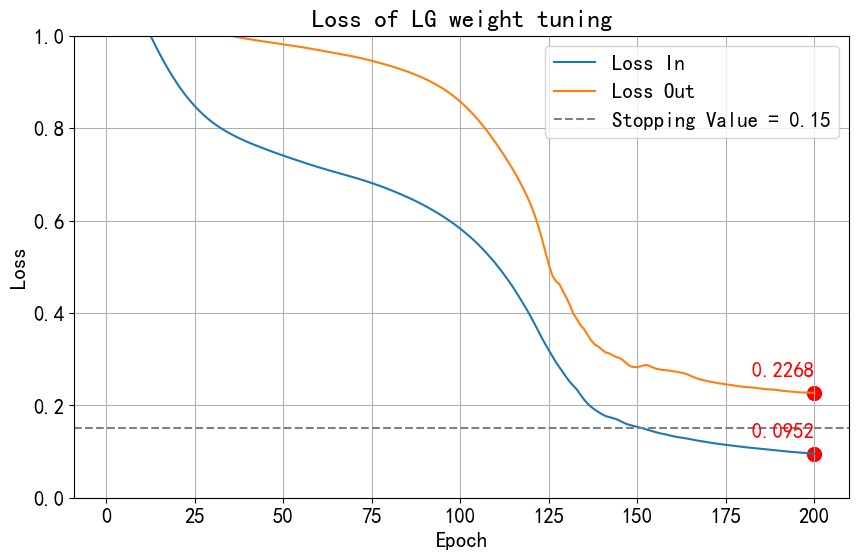

In [57]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.22643645107746124
11486315520.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


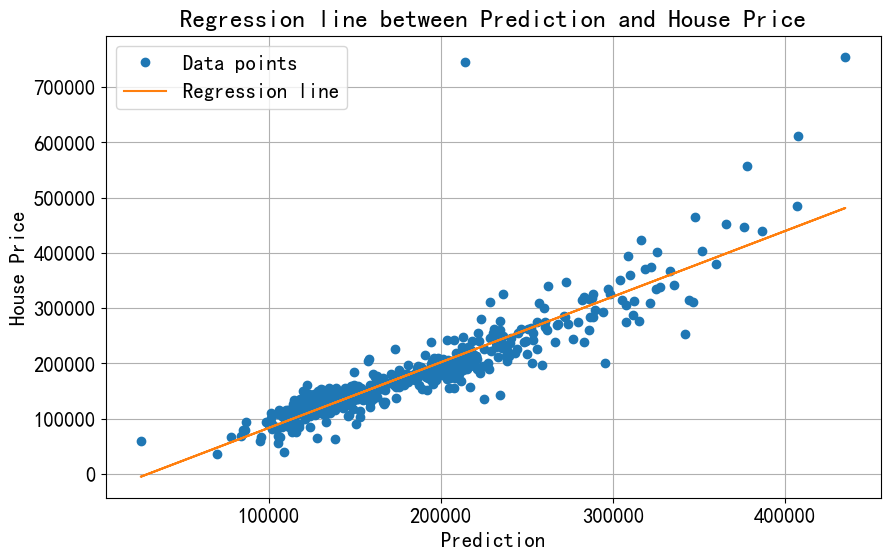

In [58]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB l2

In [62]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-1
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_regulization.append(model_11)

Epoch 1: Loss In 0.19934025406837463, Loss Out 0.5673481822013855, Learning Rate 0.1
update new model
Epoch 2: Loss In 2.5313596725463867, Loss Out 1.5081748962402344, Learning Rate 0.1
update new model
Epoch 3: Loss In 0.32304564118385315, Loss Out 0.6200357675552368, Learning Rate 0.1
update new model
Epoch 4: Loss In 0.7270957231521606, Loss Out 1.3605613708496094, Learning Rate 0.1
update new model
Epoch 5: Loss In 1.0609146356582642, Loss Out 1.6938225030899048, Learning Rate 0.1
update new model
Epoch 6: Loss In 0.8748323321342468, Loss Out 1.413489580154419, Learning Rate 0.1
update new model
Epoch 7: Loss In 0.6381592154502869, Loss Out 1.054297685623169, Learning Rate 0.1
update new model
Epoch 8: Loss In 0.5922039747238159, Loss Out 0.8866033554077148, Learning Rate 0.1
update new model
Epoch 9: Loss In 0.6979448199272156, Loss Out 0.9028292894363403, Learning Rate 0.1
update new model
Epoch 10: Loss In 0.8002219200134277, Loss Out 0.9643758535385132, Learning Rate 0.1
update

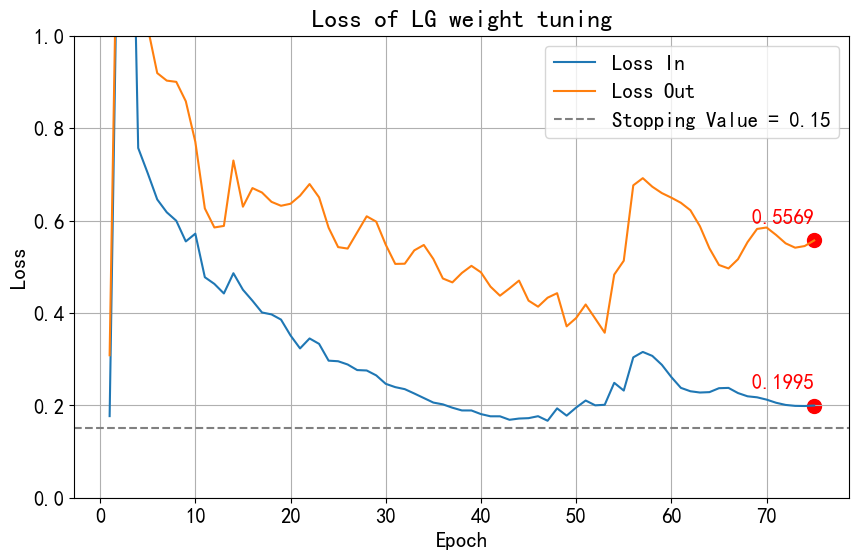

In [60]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.5008222460746765
8971059200.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


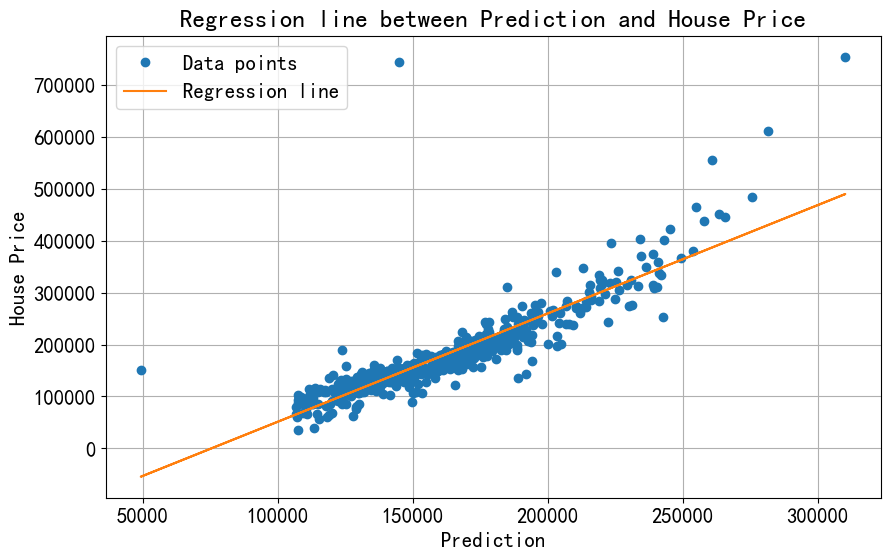

In [61]:
draw_pred_reggsion(model_11,print_error = True)

### 2. weight tuning LG UA  + regularizing_LG UA with l2  loss 

In [45]:
models_LGUA_accept = []
models_LGUA_regulization = []

#### train with LG UA

In [65]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.2 if l2 else 0.075
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_accept.append(model_11)



1
Epoch 1: Loss In 1.1757738590240479, Loss Out 1.169812798500061, Learning Rate 0.001
Epoch 2: Loss In 1.1459251642227173, Loss Out 1.1515637636184692, Learning Rate 0.00102
Epoch 3: Loss In 1.1164331436157227, Loss Out 1.1337817907333374, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 1.0872023105621338, Loss Out 1.1169768571853638, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 1.057932734489441, Loss Out 1.1003533601760864, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 1.028910756111145, Loss Out 1.0844435691833496, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 1.0002996921539307, Loss Out 1.069342851638794, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 0.9722021222114563, Loss Out 1.0550321340560913, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 0.9448265433311462, Loss Out 1.0415745973587036, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 0.9183592796325684, Loss Out 1.0289586782455444, Learning Rate 0.0011950925686223112
Epoch 11: L

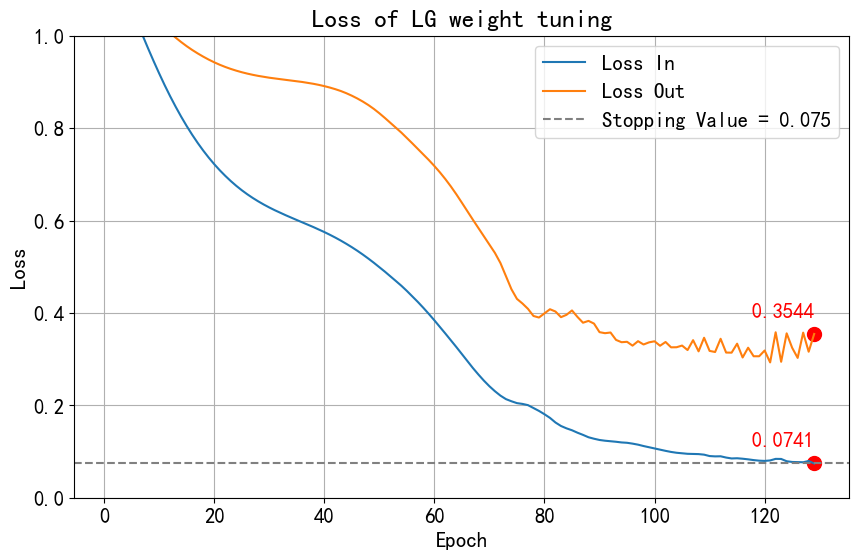

In [66]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.35443225502967834
10233542656.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


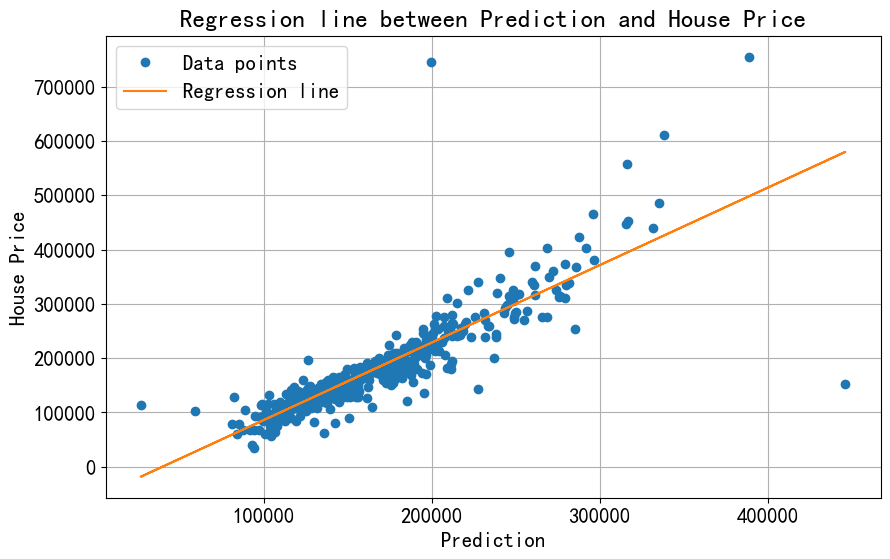

In [67]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with LG UA l2

In [68]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_regulization.append(model_11)

Epoch 1: Loss In 0.2498188018798828, Loss Out 0.5301651954650879, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.24658063054084778, Loss Out 0.4996389150619507, Learning Rate 0.00102
update new model
Epoch 3: Loss In 0.2461213320493698, Loss Out 0.4829653203487396, Learning Rate 0.0010404000000000001
update new model
Epoch 4: Loss In 0.24446812272071838, Loss Out 0.4797724187374115, Learning Rate 0.0010612080000000001
update new model
Epoch 5: Loss In 0.24268576502799988, Loss Out 0.48434367775917053, Learning Rate 0.0010824321600000002
update new model
Epoch 6: Loss In 0.24144169688224792, Loss Out 0.4934988021850586, Learning Rate 0.0011040808032000001
update new model
Epoch 7: Loss In 0.24041616916656494, Loss Out 0.5006582736968994, Learning Rate 0.0011261624192640003
update new model
Epoch 8: Loss In 0.23911555111408234, Loss Out 0.5006821155548096, Learning Rate 0.0011486856676492802
update new model
Epoch 9: Loss In 0.23775555193424225, Loss Out 0.4941466450691223, Lear

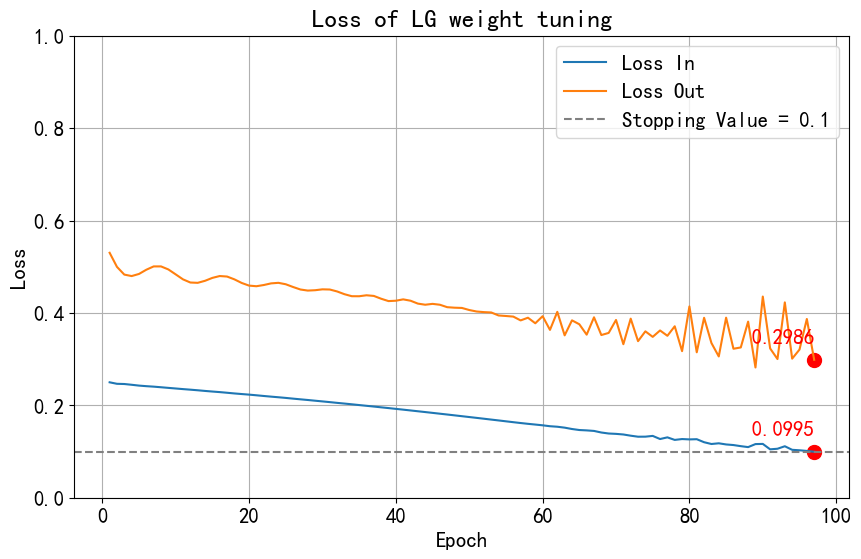

In [69]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2510243058204651
11435991040.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


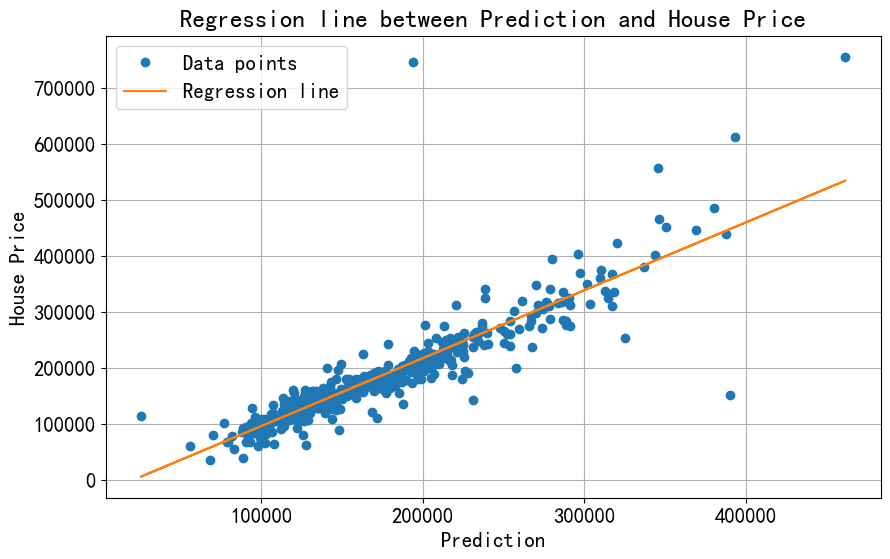

In [70]:
draw_pred_reggsion(model_11,print_error = True)

### 3. weight tuning EB LG UA  + regularizing EB LG UA  with l2  loss 

In [71]:
models_EBLGUA_accept = []
models_EBLGUA_regulization = []

#### train with EB LG UA 

In [72]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.05
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_accept.append(model_11)



1
Epoch 1: Loss In 1.4276401996612549, Loss Out 1.5052865743637085, Learning Rate 0.001
Epoch 2: Loss In 1.3880255222320557, Loss Out 1.4694892168045044, Learning Rate 0.00102
Epoch 3: Loss In 1.349015235900879, Loss Out 1.4350416660308838, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 1.3108339309692383, Loss Out 1.402029037475586, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 1.2734557390213013, Loss Out 1.3703547716140747, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 1.236990213394165, Loss Out 1.3399379253387451, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 1.2015693187713623, Loss Out 1.3108532428741455, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 1.1672649383544922, Loss Out 1.283155083656311, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 1.13417649269104, Loss Out 1.2568448781967163, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 1.102420449256897, Loss Out 1.2319341897964478, Learning Rate 0.0011950925686223112
Epoch 11: Loss

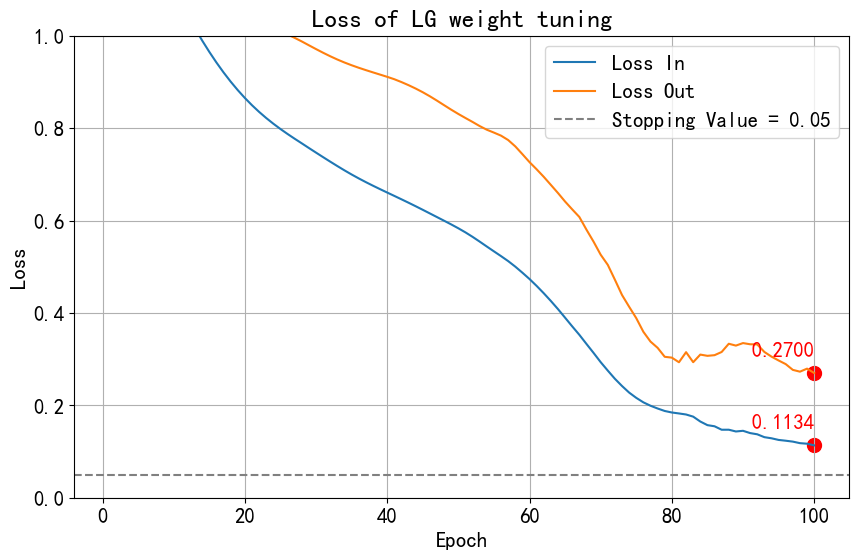

In [73]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2674473524093628
10814138368.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


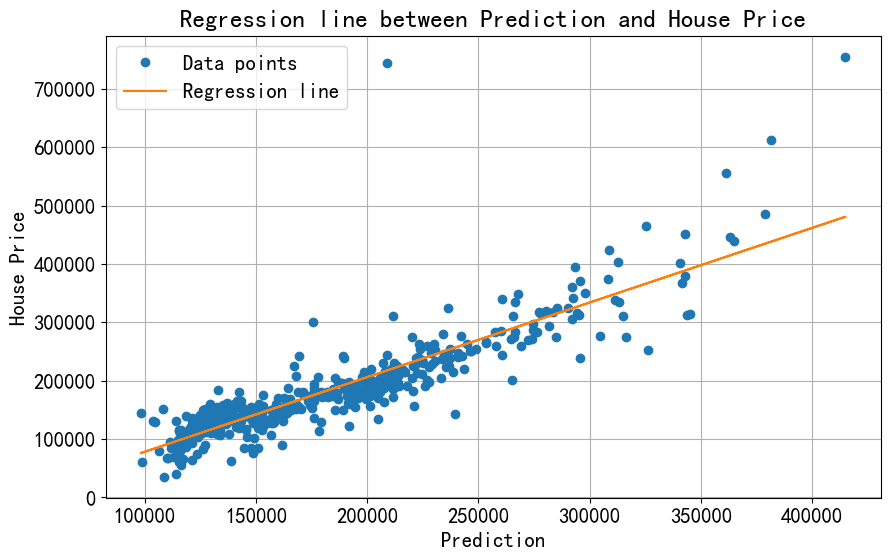

In [74]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB LG UA l2

In [75]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_regulization.append(model_11)

Epoch 1: Loss In 0.21635320782661438, Loss Out 0.37264007329940796, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.2165393829345703, Loss Out 0.3843781054019928, Learning Rate 0.00102
update new model
Epoch 3: Loss In 0.21249651908874512, Loss Out 0.37800854444503784, Learning Rate 0.0010404000000000001
update new model
Epoch 4: Loss In 0.21078169345855713, Loss Out 0.3741706311702728, Learning Rate 0.0010612080000000001
update new model
Epoch 5: Loss In 0.21039852499961853, Loss Out 0.37451744079589844, Learning Rate 0.0010824321600000002
update new model
Epoch 6: Loss In 0.20837685465812683, Loss Out 0.37400656938552856, Learning Rate 0.0011040808032000001
update new model
Epoch 7: Loss In 0.20596259832382202, Loss Out 0.3739142417907715, Learning Rate 0.0011261624192640003
update new model
Epoch 8: Loss In 0.20449954271316528, Loss Out 0.3752441704273224, Learning Rate 0.0011486856676492802
update new model
Epoch 9: Loss In 0.2033511996269226, Loss Out 0.3753679096698761, L

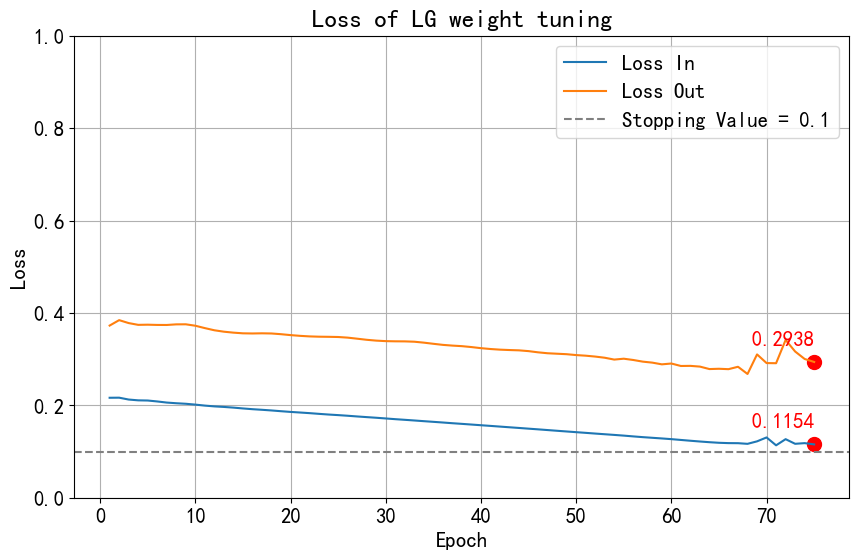

In [76]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.25985798239707947
10604532736.0


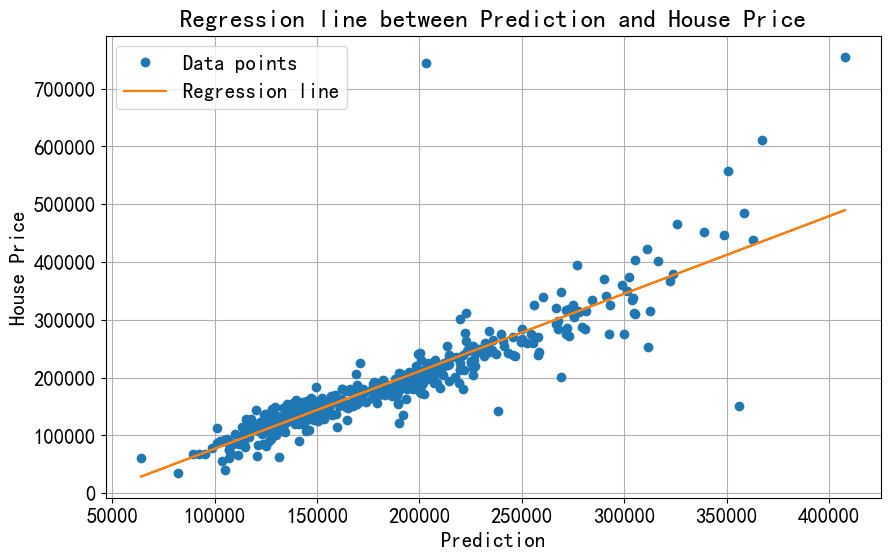

In [77]:
draw_pred_reggsion(model_11,print_error = True)

### 4. weight tuning EB   + regularizing EB DO

In [78]:
models_EBDO_accept = []
models_EBDO_regulization = []

#### train with EB 

In [79]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_accept.append(model_11)



1
Epoch 1: Loss In 1.3907244205474854, Loss Out 1.4293617010116577, Learning Rate 0.001
Epoch 2: Loss In 1.3625952005386353, Loss Out 1.40305495262146, Learning Rate 0.001
Epoch 3: Loss In 1.3354096412658691, Loss Out 1.3782461881637573, Learning Rate 0.001
Epoch 4: Loss In 1.309281826019287, Loss Out 1.354809045791626, Learning Rate 0.001
Epoch 5: Loss In 1.2841562032699585, Loss Out 1.332709550857544, Learning Rate 0.001
Epoch 6: Loss In 1.2600773572921753, Loss Out 1.3119499683380127, Learning Rate 0.001
Epoch 7: Loss In 1.2368147373199463, Loss Out 1.2923901081085205, Learning Rate 0.001
Epoch 8: Loss In 1.214375615119934, Loss Out 1.2739388942718506, Learning Rate 0.001
Epoch 9: Loss In 1.1927741765975952, Loss Out 1.2565149068832397, Learning Rate 0.001
Epoch 10: Loss In 1.1719496250152588, Loss Out 1.2400530576705933, Learning Rate 0.001
Epoch 11: Loss In 1.151780128479004, Loss Out 1.2244939804077148, Learning Rate 0.001
Epoch 12: Loss In 1.1322638988494873, Loss Out 1.20976662

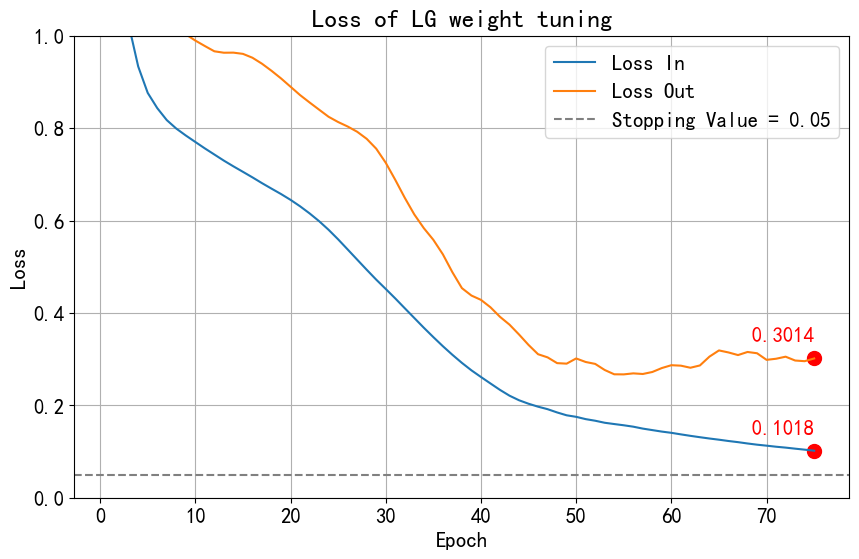

In [102]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.30411389470100403
12822299648.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


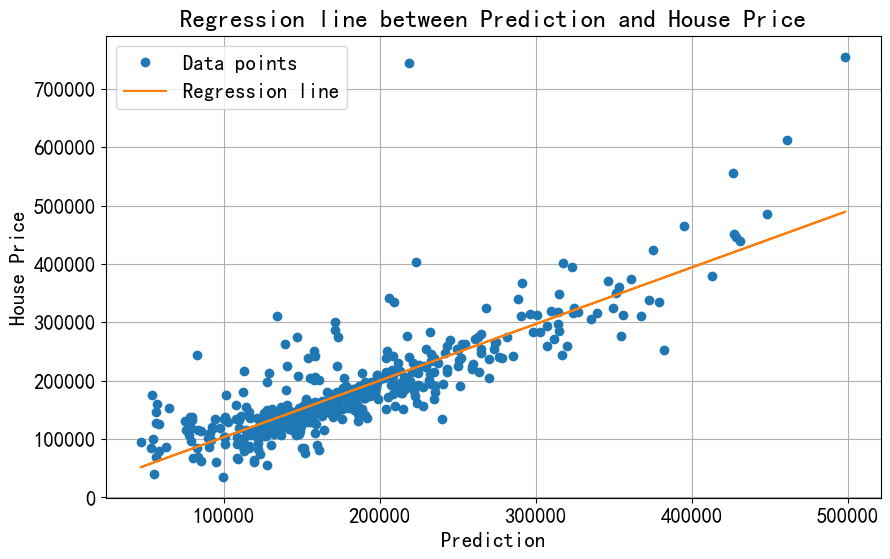

In [103]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [104]:
EB = True
LG = False
UA= False
DO = True
BN = False
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_regulization.append(model_11)

Epoch 1: Loss In 0.6421376466751099, Loss Out 0.30411389470100403, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.5471259951591492, Loss Out 0.4886404871940613, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.5565440058708191, Loss Out 0.6077987551689148, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.4385630488395691, Loss Out 0.548787534236908, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.5039022564888, Loss Out 0.4970521628856659, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.468938946723938, Loss Out 0.42838090658187866, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.4051414430141449, Loss Out 0.4081907868385315, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.47026100754737854, Loss Out 0.4011361002922058, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.47894272208213806, Loss Out 0.38694238662719727, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.4162043035030365, Loss Out 0.3670252859592438, Learni

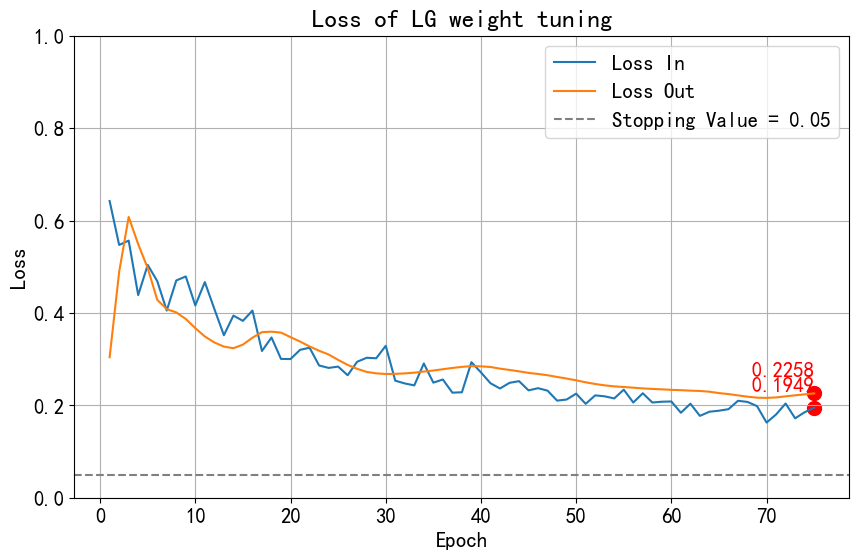

In [105]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.22903701663017273
12126996480.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


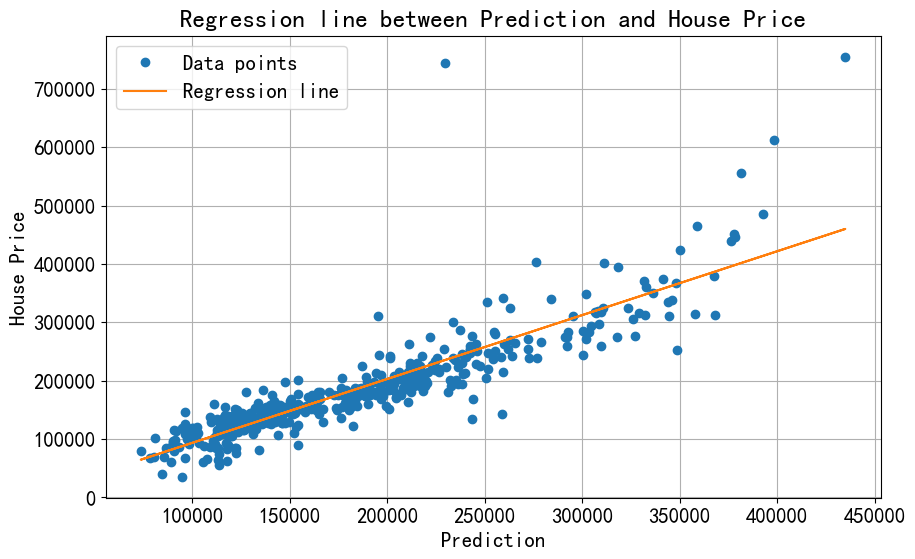

In [106]:
draw_pred_reggsion(model_11,print_error = True)

### 5. weight tuning EB   + regularizing EB DO

In [107]:
models_EBBN_accept = []
models_EBBN_regulization = []

#### train with EB 

In [108]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_accept.append(model_11)



Epoch 1: Loss In 1.9861416816711426, Loss Out 2.307358503341675, Learning Rate 0.001
Epoch 2: Loss In 1.852182149887085, Loss Out 2.176486015319824, Learning Rate 0.001
Epoch 3: Loss In 1.7492300271987915, Loss Out 2.081301212310791, Learning Rate 0.001
Epoch 4: Loss In 1.6674680709838867, Loss Out 1.9975229501724243, Learning Rate 0.001
Epoch 5: Loss In 1.6073306798934937, Loss Out 1.9411717653274536, Learning Rate 0.001
Epoch 6: Loss In 1.5644303560256958, Loss Out 1.911637783050537, Learning Rate 0.001
Epoch 7: Loss In 1.5239918231964111, Loss Out 1.877960205078125, Learning Rate 0.001
Epoch 8: Loss In 1.4837334156036377, Loss Out 1.837769865989685, Learning Rate 0.001
Epoch 9: Loss In 1.4441288709640503, Loss Out 1.7885725498199463, Learning Rate 0.001
Epoch 10: Loss In 1.4060287475585938, Loss Out 1.7357048988342285, Learning Rate 0.001
Epoch 11: Loss In 1.370495080947876, Loss Out 1.6818968057632446, Learning Rate 0.001
Epoch 12: Loss In 1.3403751850128174, Loss Out 1.63376033306

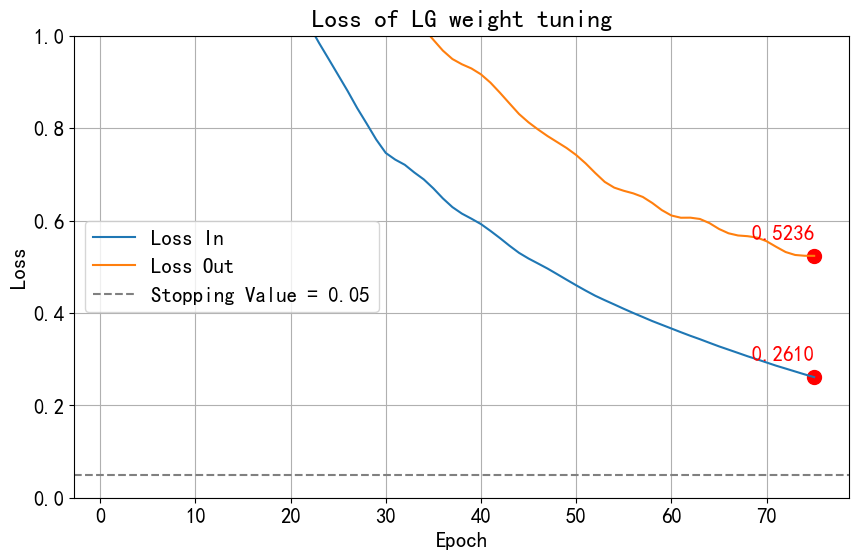

In [109]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.5166227221488953
10200172544.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


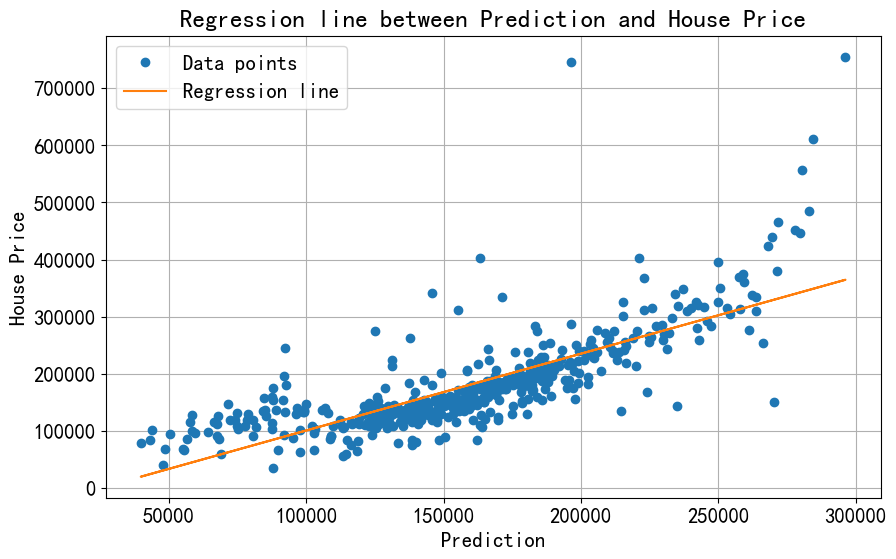

In [110]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [113]:
EB = True
LG = False
UA= False
DO = False
BN = True
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 50

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_regulization.append(model_11)

Epoch 1: Loss In 0.03298895061016083, Loss Out 0.5043054223060608, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.22212207317352295, Loss Out 0.7814711332321167, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.11840333789587021, Loss Out 0.4219760000705719, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.09133898466825485, Loss Out 0.3173542618751526, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.06582712382078171, Loss Out 0.3204265534877777, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.08654137700796127, Loss Out 0.3772296905517578, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.08780194073915482, Loss Out 0.37849104404449463, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.07051976770162582, Loss Out 0.3411061465740204, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.06072121486067772, Loss Out 0.3043966293334961, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.0590682327747345, Loss Out 0.29634559154510

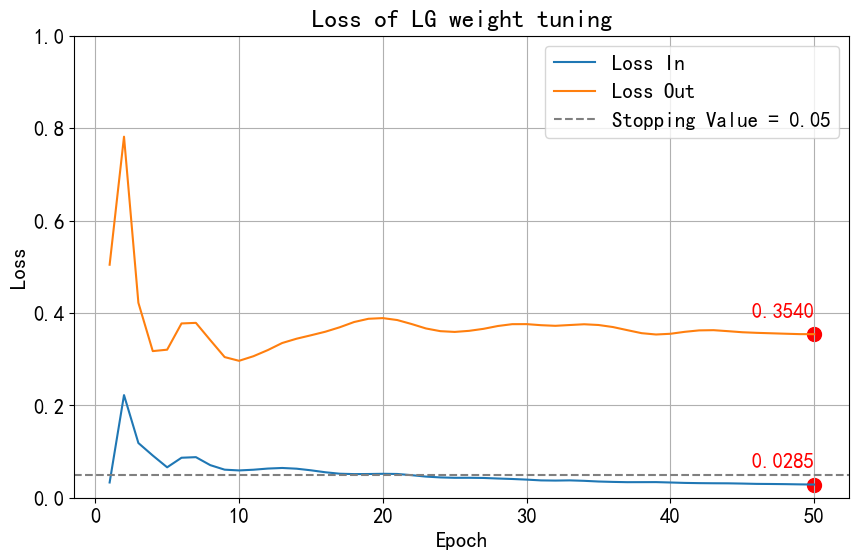

In [114]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.3556588888168335
11841227776.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


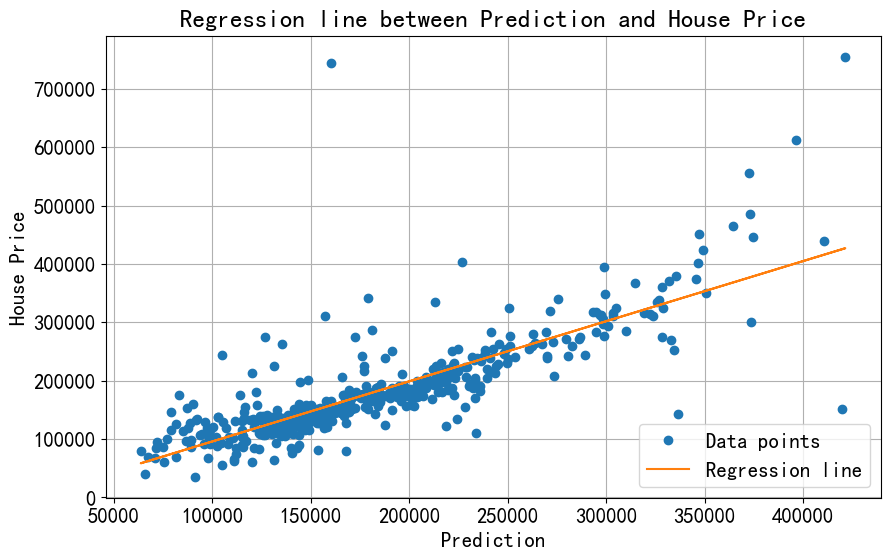

In [115]:
draw_pred_reggsion(model_11,print_error = True)

In [ ]:
# 遞迴遮罩和判定
while not all_nodes_pruned:
    mask_and_prune(model_11)

## Conclusion
#### HW4Update 
#### 1.這次把程式整個大改，把訓練與regulization分開，並且寫成一個訓練的函數，可以選擇是否要EB、LG、UA、DO、BN以及調整訓練模式與regulization模式，雖然最後的code在LG+UA的地方和老師有些差異(老師的LG判定放在迴圈最後，我把LG放在forward後面)，但結果看下來是好的。
#### 2.將訓練與regulization分開後，訓練成本大幅下降，從原本50000步左右變成大約75步，應該是因為加上l2後損失函數圖形變得太複雜，以及沒有l2的話超過75步後容易overfitting導致。一開始把l2丟掉時沒有發現overfitting，等到後來發現model 有訓練模式與評估模式，才發現超級大過擬。
#### 3.小問題，DO layer加上去後拿來做UA的ReduceLROnPlateau就失效了，不管loss 多大lr就是不會變，網路上也找不到相關的議題，可能需要跟老師憶起研究一下。

##### HW3Update 這次加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

##### HW2update 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 6 layer 改成 4layer  214 100 50 11 1 
## initial weight:
#### Xavier 
## Activation:
#### 主要用LeakyRELU
## Loss:
#### MSE ,把 l2 regulization 去掉後從50000步降到75步...
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 6^10-4, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## learn rate scheduler
#### 用ReduceLROnPlateau做UA, 每次變成0.9倍, loss 5輪沒降才會調, 停止值設 6^10-4
## DO
#### 每層被丟掉ˋ的機率都是0.1
## BN
#### 做的是BatchNorm1d，不確定和BatchNorm2d有什麼差別
## Ensembles
#### 下次一定做

